In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.nn as nn


In [2]:
df = pd.read_csv('df_scaled.csv')

In [3]:
df['track_popularity'].head()

0    0.617978
1    0.629213
2    0.662921
3    0.550562
4    0.651685
Name: track_popularity, dtype: float64

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau





numerical_features = ['speechiness', 'acousticness', 'instrumentalness', 
                      'liveness', 'valence', 'tempo', 'duration_ms']

X = df[numerical_features].values
y = df['track_popularity'].values  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Deje este escalado estandar porque mejora los resultados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Conversion a tensores de pytorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modelo 1
# class MusicNet(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(MusicNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.relu = nn.ReLU()
#         self.fc3 = nn.Linear(64, output_size)
#         self.relu = nn.ReLU()
    
#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
class MusicNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MusicNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(p=0.3)  # Dropout after first layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(p=0.3)  # Dropout after second layer
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Applying dropout
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  # Applying dropout
        x = self.fc3(x)
        return x

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

input_size = X_train.shape[1]
output_size = 1  
hidden_size = 64
model = MusicNet(input_size, hidden_size, output_size)
loss_fn = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

test_losses = []

epochs = 20

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = 0
    model.train()  
    
    for batch, (X_batch, y_batch) in enumerate(train_dataloader):
        
        # Forward pass
        y_pred = model(X_batch).squeeze()
        loss = loss_fn(y_pred, y_batch)
        
        # Backward pass
        optimizer.zero_grad()  
        loss.backward()        
        optimizer.step()       

        train_loss += loss.item()
        scheduler.step(loss)
        if batch % 400 == 0:
            print(f"Batch {batch}, Loss: {loss.item()}")
    
    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Evaluation Loop
    model.eval()  
    test_loss = 0
    
    with torch.no_grad():  
        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)  
    print(f"Test Loss: {avg_test_loss:.4f}")


c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1
-------------------------------
Batch 0, Loss: 0.3585638999938965
Batch 400, Loss: 0.030539363622665405
Train Loss: 0.0515
Test Loss: 0.0374
Epoch 2
-------------------------------
Batch 0, Loss: 0.04470125213265419
Batch 400, Loss: 0.048637714236974716
Train Loss: 0.0408
Test Loss: 0.0388
Epoch 3
-------------------------------
Batch 0, Loss: 0.05520002543926239
Batch 400, Loss: 0.03425272926688194
Train Loss: 0.0393
Test Loss: 0.0372
Epoch 4
-------------------------------
Batch 0, Loss: 0.0299883671104908
Batch 400, Loss: 0.0356917530298233
Train Loss: 0.0385
Test Loss: 0.0370
Epoch 5
-------------------------------
Batch 0, Loss: 0.035383932292461395
Batch 400, Loss: 0.026821346953511238
Train Loss: 0.0381
Test Loss: 0.0372
Epoch 6
-------------------------------
Batch 0, Loss: 0.03495052084326744
Batch 400, Loss: 0.03700048848986626
Train Loss: 0.0378
Test Loss: 0.0367
Epoch 7
-------------------------------
Batch 0, Loss: 0.04246116429567337
Batch 400, Loss: 0.04645685479

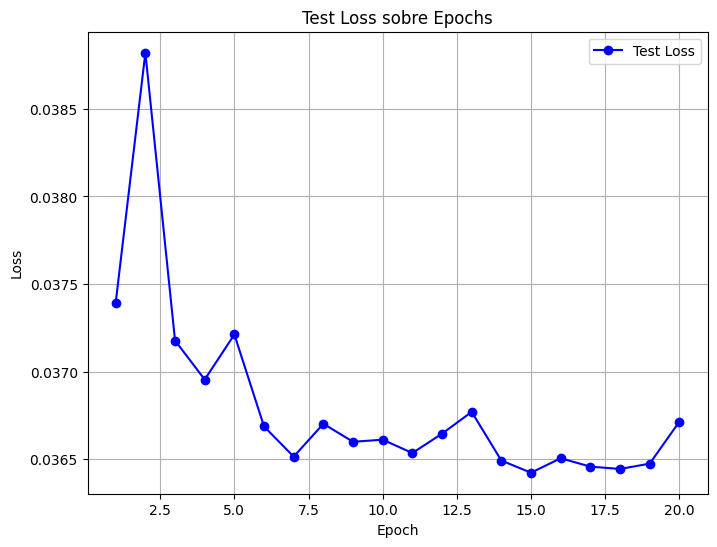

In [21]:
import matplotlib.pyplot as plt


epochs_list = list(range(1, epochs + 1))

# Plot de los resultados
plt.figure(figsize=(8, 6))
plt.plot(epochs_list, test_losses, marker='o', linestyle='-', color='b', label='Test Loss')
plt.title('Test Loss sobre Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
import math

rmse = math.sqrt(avg_test_loss)
print(f"RMSE: {rmse:.4f}")


RMSE: 0.1916


Esto significa que le erra por 20 unidades. Vamos a mejorar

In [7]:

numerical_features_2 = ['acousticness', 'instrumentalness', 
                      'liveness', 'valence', 'tempo']

X = df[numerical_features_2].values
y = df['track_popularity'].values  # Target track_popularity


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
#modelo 2
class MusicNet_2(nn.Module):
    def __init__(self, input_size, output_size):
        super(MusicNet_2, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


input_size = X_train.shape[1]
output_size = 1  

model = MusicNet_2(input_size, output_size)
loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)
test_losses = []

epochs = 20

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = 0
    model.train()  
    
    for batch, (X_batch, y_batch) in enumerate(train_dataloader):
        # Forward pass
        y_pred = model(X_batch).squeeze()
        loss = loss_fn(y_pred, y_batch)
        
        # Backward pass
        optimizer.zero_grad()  
        loss.backward()        
        optimizer.step()       
        train_loss += loss.item()

        if batch % 400 == 0:
            print(f"Batch {batch}, Loss: {loss.item()}")
    
    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Evaluation Loop
    model.eval() 
    test_loss = 0
    
    with torch.no_grad():  
        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss) 
    print(f"Test Loss: {avg_test_loss:.4f}")


Epoch 1
-------------------------------
Batch 0, Loss: 0.10246619582176208
Batch 400, Loss: 0.033541928976774216
Train Loss: 0.0410
Test Loss: 0.0372
Epoch 2
-------------------------------
Batch 0, Loss: 0.04095844179391861
Batch 400, Loss: 0.04852212965488434
Train Loss: 0.0384
Test Loss: 0.0370
Epoch 3
-------------------------------
Batch 0, Loss: 0.0437997467815876
Batch 400, Loss: 0.024035772308707237
Train Loss: 0.0381
Test Loss: 0.0376
Epoch 4
-------------------------------
Batch 0, Loss: 0.03354320302605629
Batch 400, Loss: 0.022595085203647614
Train Loss: 0.0380
Test Loss: 0.0376
Epoch 5
-------------------------------
Batch 0, Loss: 0.04426751285791397
Batch 400, Loss: 0.03203750401735306
Train Loss: 0.0380
Test Loss: 0.0375
Epoch 6
-------------------------------
Batch 0, Loss: 0.04275990650057793
Batch 400, Loss: 0.02853943593800068
Train Loss: 0.0380
Test Loss: 0.0385
Epoch 7
-------------------------------
Batch 0, Loss: 0.04056654870510101
Batch 400, Loss: 0.0387053973

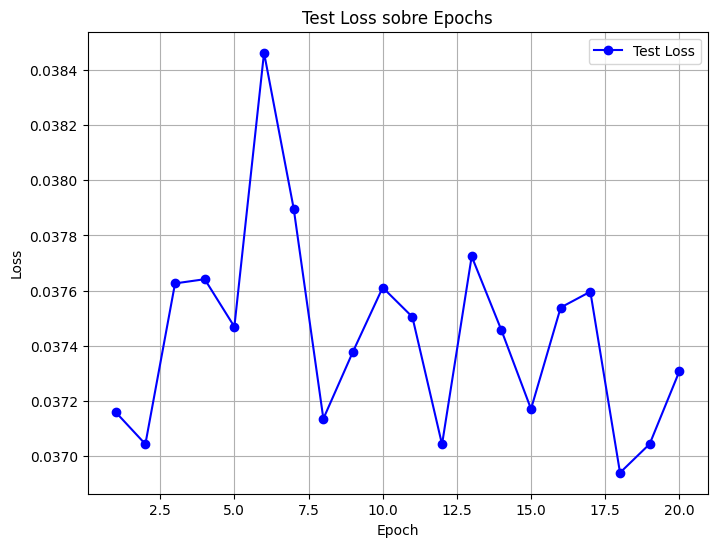

In [9]:
import matplotlib.pyplot as plt


epochs_list = list(range(1, epochs + 1))


plt.figure(figsize=(8, 6))
plt.plot(epochs_list, test_losses, marker='o', linestyle='-', color='b', label='Test Loss')
plt.title('Test Loss sobre Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
rmse = math.sqrt(avg_test_loss)
print(f"RMSE: {rmse:.4f}")

RMSE: 0.1932


In [11]:
df_pca = pd.read_csv('df_pca9.csv')

In [12]:
df_pca.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,track_id,track_popularity
0,-1.228247,-2.007737,0.636795,-1.357469,-1.137151,-1.301107,-0.040412,-0.705792,-0.603308,6f807x0ima9a1j3VPbc7VN,0.617978
1,-0.814656,-1.237786,0.390595,-1.321949,-1.275996,-0.900223,1.379120,0.766448,0.605321,0r7CVbZTWZgbTCYdfa2P31,0.629213
2,-1.380825,-1.835965,0.500640,-1.146859,-1.218530,-1.204166,-0.001245,-0.475784,-0.197209,1z1Hg7Vb0AhHDiEmnDE79l,0.662921
3,-1.276420,-1.840713,1.212820,-0.632802,-1.227607,-0.654282,0.240339,0.151130,-0.227065,75FpbthrwQmzHlBJLuGdC7,0.550562
4,-1.036401,-1.130778,0.537385,-1.468597,-1.034739,-1.504985,-0.175239,-0.388876,0.052818,1e8PAfcKUYoKkxPhrHqw4x,0.651685


In [13]:

numerical_features = ['PC0', 'PC1', 'PC2', 
                      'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']

X = df_pca[numerical_features].values
y = df_pca['track_popularity'].values  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Deje este escalado estandar porque mejora los resultados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Conversion a tensores de pytorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modelo 1
class MusicNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(MusicNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


input_size = X_train.shape[1]
output_size = 1  

model = MusicNet(input_size, output_size)
loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)
test_losses = []

epochs = 20

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = 0
    model.train()  
    
    for batch, (X_batch, y_batch) in enumerate(train_dataloader):
        
        # Forward pass
        y_pred = model(X_batch).squeeze()
        loss = loss_fn(y_pred, y_batch)
        
        # Backward pass
        optimizer.zero_grad()  
        loss.backward()        
        optimizer.step()       

        train_loss += loss.item()

        if batch % 400 == 0:
            print(f"Batch {batch}, Loss: {loss.item()}")
    
    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Evaluation Loop
    model.eval()  
    test_loss = 0
    
    with torch.no_grad():  
        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)  
    print(f"Test Loss: {avg_test_loss:.4f}")


Epoch 1
-------------------------------
Batch 0, Loss: 0.15659567713737488
Batch 400, Loss: 0.04827439412474632
Train Loss: 0.0404
Test Loss: 0.0375
Epoch 2
-------------------------------
Batch 0, Loss: 0.03796084225177765
Batch 400, Loss: 0.034992560744285583
Train Loss: 0.0381
Test Loss: 0.0372
Epoch 3
-------------------------------
Batch 0, Loss: 0.04244299605488777
Batch 400, Loss: 0.04971121624112129
Train Loss: 0.0378
Test Loss: 0.0369
Epoch 4
-------------------------------
Batch 0, Loss: 0.03490537405014038
Batch 400, Loss: 0.04474978893995285
Train Loss: 0.0377
Test Loss: 0.0371
Epoch 5
-------------------------------
Batch 0, Loss: 0.036964815109968185
Batch 400, Loss: 0.028453532606363297
Train Loss: 0.0375
Test Loss: 0.0370
Epoch 6
-------------------------------
Batch 0, Loss: 0.02561306580901146
Batch 400, Loss: 0.029908429831266403
Train Loss: 0.0373
Test Loss: 0.0369
Epoch 7
-------------------------------
Batch 0, Loss: 0.04056328535079956
Batch 400, Loss: 0.03675742

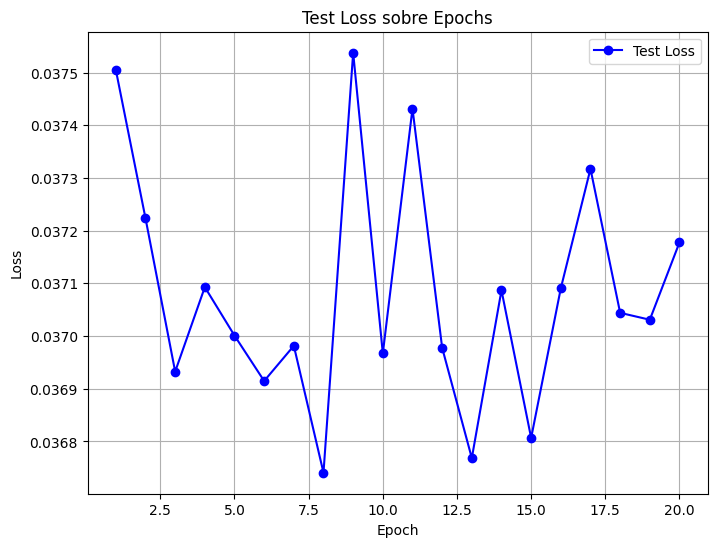

In [14]:
# Plot de los resultados
plt.figure(figsize=(8, 6))
plt.plot(epochs_list, test_losses, marker='o', linestyle='-', color='b', label='Test Loss')
plt.title('Test Loss sobre Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:

rmse = math.sqrt(avg_test_loss)
print(f"RMSE: {rmse:.4f}")

RMSE: 0.1928
